# INF367: MANDATORY 2

## Group 4: Snorre Solli Håland, Runar Fosse, Sander Marx

## Imports

In [1]:
from sklearn.datasets import load_iris
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


#Qiskit & qiskit_machine_learning
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler


#Import warnings filter
from warnings import simplefilter
#Ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

#Random generator seed
algorithm_globals.random_seed = 8008135

#Some other libs
import numpy as np
import matplotlib.pyplot as plt
import time

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### 1. Load dataset

In [2]:
seed = 8008135
data = load_iris()
X = data.data
y = data.target

print(data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [3]:
print(f"Shape of feature: {X.shape}")
print(f"Shape of target: {y.shape}")

print(f"Range of data MIN: {np.min(X)}, MAX: {np.max(X)}")



print(f"Unique target values: {list(data.target_names)}")
print(f"Unique feature names: {list(data.feature_names)}")

print(X[:-130, :])

Shape of feature: (150, 4)
Shape of target: (150,)
Range of data MIN: 0.1, MAX: 7.9
Unique target values: ['setosa', 'versicolor', 'virginica']
Unique feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]]


Our data is data is 4 dimensional and our targets are one dimensional.
We have 150 data points with range from 0.1 to 7.9.


We have sepal width and length aswell as petal width and length for our features. And our targets are setosa, versicolor and virginica.

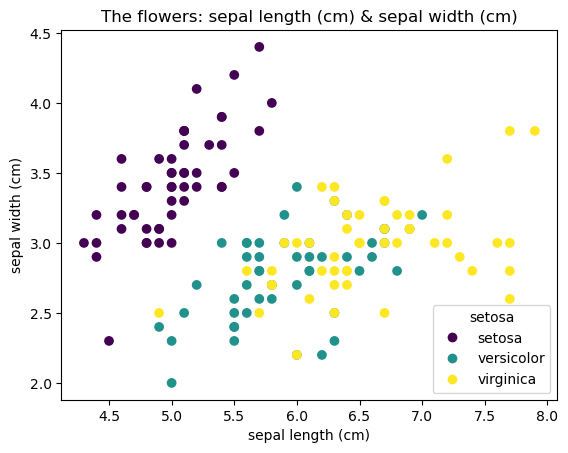

In [4]:
#Combine X and y data into numpy array
combined_data = np.c_[X, y]


#Use the IrisPlot from assignment 6 solutions
def IrisPlot(f_Idx1, f_Idx2):
    #Make plot
    scatter = plt.scatter(combined_data[:, f_Idx1], combined_data[:, f_Idx2], c=combined_data[:, -1])
    plt.legend(
        scatter.legend_elements()[0], data.target_names, loc="lower right", title=data.target_names[0]

    )
    plt.title("The flowers: " + data.feature_names[f_Idx1] + " & " + data.feature_names[f_Idx2])
    plt.xlabel(data.feature_names[f_Idx1])
    plt.ylabel(data.feature_names[f_Idx2])
    plt.show()


# Pick some features
f1 = np.where(np.array(data.feature_names) == "sepal length (cm)")[0][0]
f2 = np.where(np.array(data.feature_names) == "sepal width (cm)")[0][0]
f3 = np.where(np.array(data.feature_names) == "petal length (cm)")[0][0]
f4 = np.where(np.array(data.feature_names) == "petal width (cm)")[0][0]

#Test function
IrisPlot(f1,f2)

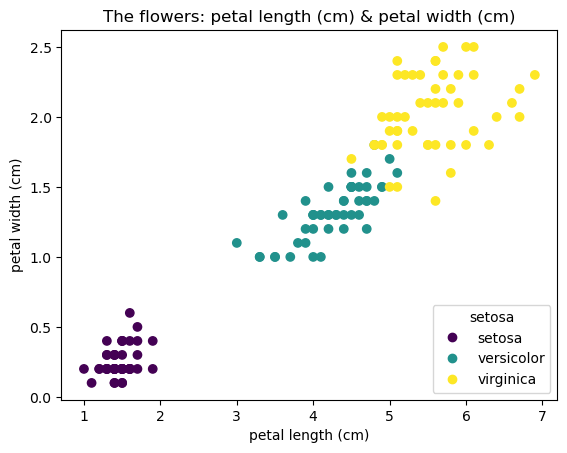

In [5]:
IrisPlot(f3,f4)

We can see from our visualizations that:
Setosa is identified by:
Lower petal width and length or sepal length is low and width is high

Versicolor and Virgincia:
Versicolor and Virgincia is a bit harder to distinguish between eachother. They have Higher petal width and length or sepal length is high and width is lower.

So we can see that petal length and width are highly correlated.

### 3. Encoding and Norm

We use Angle encoding on this dataset. We also preproess it by normalizing between -pi and pi since we use angle encoding. Again using functions from assignment 6.

In [6]:
#Normalize array between values t_min and t_max
def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

#Normalize array between -π and π. Skip label column.
def piNorm(arr):
    
    #Data dimensions
    shp = arr.shape

    #Don't normalize labels
    d = np.array(arr[:,-1],dtype=float).reshape(shp[0],1)
    
    #Normalize everything else, column by column
    for i in reversed(range(shp[1]-1)):
        d = np.insert(d, 0, normalize(arr[:,i], -np.pi,np.pi), axis=1)
    
    return d

# Norm all rows and columns exept the last column that is y
X_norm = piNorm(combined_data[:, :-1])

In [7]:
print(f"Shape of feature: {X_norm.shape}")
print(f"Shape of target: {y.shape}")

print(f"Range of data MIN: {np.min(X_norm)}, MAX: {np.max(X_norm)}")



print(f"Unique target values: {list(data.target_names)}")
print(f"Unique feature names: {list(data.feature_names)}")

Shape of feature: (150, 4)
Shape of target: (150,)
Range of data MIN: -3.141592653589793, MAX: 3.141592653589793
Unique target values: ['setosa', 'versicolor', 'virginica']
Unique feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [8]:
num_features = X_norm.shape[1]

### 4. Loss function
We use cross-entropy as our loss function.

In [9]:
#Used to get prob distr
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=-1, keepdims=True)

#Cross entropy loss function
def loss_function(predictions, true_labels):
    """
    Compute the cross-entropy loss.
    :return: Cross-entropy loss.
    """
    # Convert raw predictions to probability distributions
    prob_distributions = softmax(predictions)
    
    # Compute cross-entropy loss
    log_preds = np.log(prob_distributions + 1e-10)  # small constant added to prevent log(0)
    return -np.mean(np.sum(true_labels * log_preds, axis=1))


### 5. Split data

Split into 70/15/15

In [10]:
X_train, X_val_test, y_train, y_val_test = model_selection.train_test_split(
    X_norm, y, test_size = 0.3, shuffle = True, random_state=seed)

# Shuffle and split the data into validation and test sets with a ratio of 0.5/0.5:
X_val, X_test, y_val, y_test = model_selection.train_test_split(X_val_test, y_val_test, test_size = 0.5, shuffle = True, random_state=seed)

print(X_val)
print(y_val)

[[ 0.34906585  0.26179939  0.79871     1.6       ]
 [ 0.52359878 -1.04719755  1.75716199  2.2       ]
 [-0.6981317   3.14159265 -2.60911932  0.4       ]
 [ 2.7925268   1.57079633  2.92860332  2.2       ]
 [ 1.74532925 -0.52359878  2.07664599  2.1       ]
 [ 0.52359878 -0.26179939  1.65066733  1.8       ]
 [-1.91986218  0.26179939 -2.71561399  0.2       ]
 [ 0.6981317  -0.52359878  1.97015133  2.2       ]
 [-1.91986218  0.         -2.92860332  0.2       ]
 [ 0.34906585  0.26179939  2.18314066  2.5       ]
 [ 0.6981317  -0.52359878  1.33118333  2.        ]
 [-2.44346095  0.         -2.82210865  0.2       ]
 [ 2.7925268  -0.52359878  2.28963532  2.3       ]
 [-1.74532925  0.78539816 -2.71561399  0.2       ]
 [-2.96705973  0.         -2.82210865  0.2       ]
 [ 0.6981317  -0.52359878  1.65066733  1.8       ]
 [-0.34906585  0.          0.90520466  1.8       ]
 [ 1.04719755 -0.26179939  1.75716199  2.4       ]
 [-2.0943951   1.04719755 -2.71561399  0.1       ]
 [ 1.04719755 -1.83259571  1.97

### 6. Train QNN


We train our parameterized circuits.

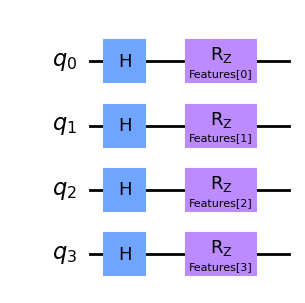

In [11]:
#ANGLE ENCODING
encoder = QuantumCircuit(num_features)

#Input Vector for encoding the features
ip = ParameterVector('Features',num_features) 

for i in range(num_features):
    encoder.h(i)
    encoder.rz(ip[i], i)

encoder.draw('mpl')

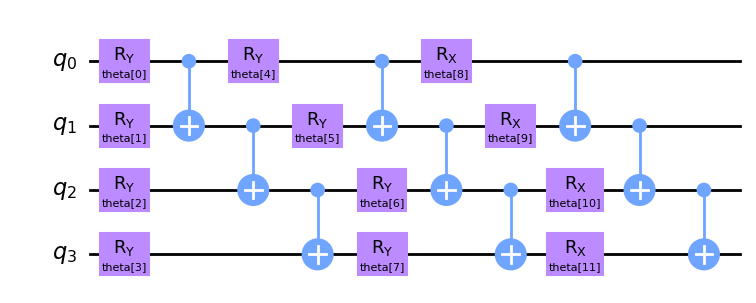

In [12]:
#param circuit for training weights
ansatz1 = QuantumCircuit(num_features)


# Define ParameterVectors
theta1 = ParameterVector('theta', 3*num_features)  # For the Ry rotations

# Parameterized Layer: Ry rotations
for i in range(num_features):
    ansatz1.ry(theta1[i], i)

# Entanglement Layer: CNOT gates between adjacent qubits
for i in range(num_features-1):
    ansatz1.cx(i, i+1)
    
# Parameterized Layer: Ry rotations
for i in range(num_features):
    ansatz1.ry(theta1[i+num_features], i)

# Entanglement Layer: CNOT gates between adjacent qubits
for i in range(num_features-1):
    ansatz1.cx(i, i+1)

# Parameterized Layer: Rx rotations
for i in range(num_features):
    ansatz1.rx(theta1[i+(num_features*2)], i)

# Entanglement Layer: CNOT gates between adjacent qubits
for i in range(num_features-1):
    ansatz1.cx(i, i+1)


ansatz1.draw('mpl')  # Draw the quantum circuit

### 7. Gradient descent function


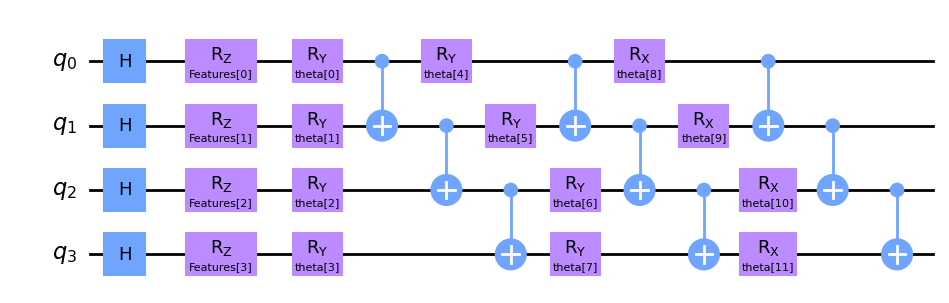

In [13]:
#Combine encoder and ansatz for our first circuit
qc = QuantumCircuit(num_features)
qc.compose(encoder, inplace=True)
qc.compose(ansatz1, inplace=True)

qc.draw('mpl')  # Draw the quantum circuit

In [14]:
#interpeter function for 3 classes that we have in the iris data set
def three_classes(x):
    binary_representation = "{:b}".format(x)
    bit_count = len(binary_representation)
    ones_count = binary_representation.count("1")
    if ones_count % 2 == 0:  # even parity
        return 0
    elif ones_count % 2 == 1 and bit_count < 4:  # odd parity with less than 4 total bits
        return 1
    else:  # odd parity with 4 or more total bits
        return 2

#To set how many output variables we want to get from a forward pass
output_shape = 3

#Import an init samplerqnn
from qiskit_machine_learning.neural_networks import SamplerQNN
#QNN for first circuit
sampler_qnn = SamplerQNN(circuit=qc, input_params=ip, weight_params=theta1, interpret=three_classes,output_shape=3)

In [15]:
print(f"Number of input features for SamplerQNN: {sampler_qnn.num_inputs}")
print(f"Number of trainable weights for SamplerQNN: {sampler_qnn.num_weights}")
print(f"Number of qbits for this circuit is {num_features} qbits")

Number of input features for SamplerQNN: 4
Number of trainable weights for SamplerQNN: 12
Number of qbits for this circuit is 4 qbits


In [16]:
#Function to one hot encode our labels to go from classification labels to numerical labels
def one_hot_encode(labels, num_classes=3):
    """Convert array of labels to one-hot encoded matrix."""
    one_hot = np.zeros((labels.shape[0], num_classes))
    one_hot[np.arange(labels.shape[0]), labels] = 1
    return one_hot


Functiuon to compute gradient
def compute_gradient(qnn, input_data, weights, true_value, epsilon=0.01):
    """
    Approximate gradient computation using finite differences.
    """
    gradients = np.zeros_like(weights)
    
    for i in range(len(weights)):
        w_plus = weights.copy()
        w_plus[i] += epsilon
        L_plus = loss_function(qnn.forward(input_data, w_plus), true_value)
        
        w_minus = weights.copy()
        w_minus[i] -= epsilon
        L_minus = loss_function(qnn.forward(input_data, w_minus), true_value)
        
        gradients[i] = (L_plus - L_minus) / (2 * epsilon)
        
    return gradients



def gradient_descent_with_early_stopping(qnn, X_train, y_train, X_val, y_val, 
                                         epochs=50, learning_rate=0.01, patience=1):
    """
    patience: number of epochs to wait for validation loss improvement before stopping, set to 1 for now
    """
    #Set weights randomly first
    weights = algorithm_globals.random.random(qnn.num_weights)
    
    best_weights = None
    best_val_loss = float('inf')
    no_improve_count = 0
    
    # Lists to store loss values for plotting later
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        for x, y in zip(X_train, y_train):
            gradients = compute_gradient(qnn, x, weights,y)
            weights = weights - learning_rate * gradients
            
        # Compute training and validation loss
        train_pred = qnn.forward(X_train, weights)
        train_loss = loss_function(train_pred, y_train)
        
        val_pred = qnn.forward(X_val, weights)
        val_loss = loss_function(val_pred, y_val)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1} - Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        
        # Check for validation loss improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = weights
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        # Early stopping if validation loss hasn't improved for "patience" epochs
        if no_improve_count >= patience:
            print("Validation loss hasn't improved for {} epochs, stopping early.".format(patience))
            break
            
    return best_weights, train_losses, val_losses


def predict(qnn, inputs, trained_weights):
    raw_outputs = qnn.forward(inputs, trained_weights)
    probabilities = softmax(raw_outputs)
    # Return the class label with the maximum probability
    return np.argmax(probabilities, axis=1)

def accuracy_score(true_labels, predicted_labels):
    true_labels = np.argmax(true_labels, axis=1)
    correct_predictions = np.sum(true_labels == predicted_labels)
    total_predictions = len(true_labels)    
    return correct_predictions / total_predictions


Epoch 1 - Training Loss: 1.2586, Validation Loss: 1.2291
Epoch 2 - Training Loss: 1.2489, Validation Loss: 1.2196
Epoch 3 - Training Loss: 1.2399, Validation Loss: 1.2107
Epoch 4 - Training Loss: 1.2312, Validation Loss: 1.2018
Epoch 5 - Training Loss: 1.2220, Validation Loss: 1.1919
Epoch 6 - Training Loss: 1.2105, Validation Loss: 1.1792
Epoch 7 - Training Loss: 1.1945, Validation Loss: 1.1612
Epoch 8 - Training Loss: 1.1712, Validation Loss: 1.1355
Epoch 9 - Training Loss: 1.1393, Validation Loss: 1.1011
Epoch 10 - Training Loss: 1.1010, Validation Loss: 1.0610
Epoch 11 - Training Loss: 1.0613, Validation Loss: 1.0207
Epoch 12 - Training Loss: 1.0253, Validation Loss: 0.9852
Epoch 13 - Training Loss: 0.9953, Validation Loss: 0.9568
Epoch 14 - Training Loss: 0.9717, Validation Loss: 0.9354
Epoch 15 - Training Loss: 0.9536, Validation Loss: 0.9201
Epoch 16 - Training Loss: 0.9398, Validation Loss: 0.9092
Epoch 17 - Training Loss: 0.9293, Validation Loss: 0.9015
Epoch 18 - Training Los

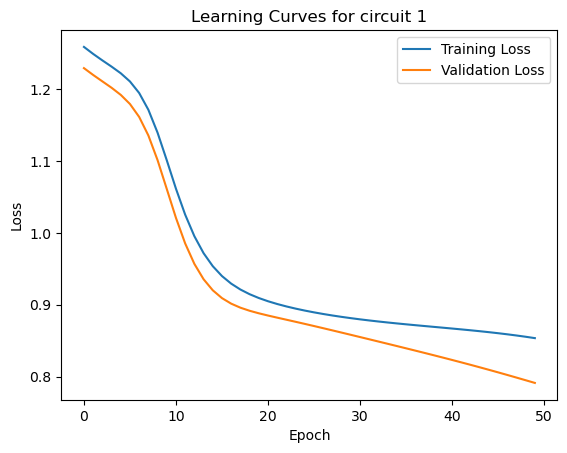

In [17]:
#Apply one hot encoding to labels
y_train = one_hot_encode(y_train)
y_val = one_hot_encode(y_val)
y_test = one_hot_encode(y_test)


start = time.time()
#Train first circuit using grad descent
trained_weights, train_losses, val_losses = gradient_descent_with_early_stopping(sampler_qnn, X_train, y_train,
                                                                                 X_val, y_val, epochs = 50)
elapsed = time.time() - start


# Plotting for circuit 1
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves for circuit 1')
plt.show()


In [18]:
print(f"Training time for circuit 1 with 8 qbits is: {round(elapsed)} seconds")

#Validation acc for circuit 1
predicted_labels_v = predict(sampler_qnn, X_val, trained_weights)
val_accuracy = accuracy_score(y_val, predicted_labels_v)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}% for circuit 1")

#Train acc for circuit 1
predicted_labels_t = predict(sampler_qnn, X_train, trained_weights)
train_accuracy = accuracy_score(y_train, predicted_labels_t)
print(f"Train Accuracy: {train_accuracy * 100:.2f}% for circuit 1")


#Test acc for circuit 1
predicted_labels = predict(sampler_qnn, X_test, trained_weights)
test_accuracy = accuracy_score(y_test, predicted_labels)

Training time for circuit 1 with 8 qbits is: 399 seconds
Validation Accuracy: 90.91% for circuit 1
Train Accuracy: 95.24% for circuit 1


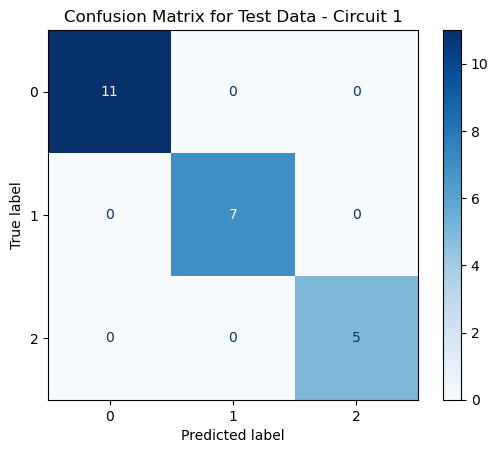

Test Accuracy: 100.00% for circuit 1


In [19]:
# Calculate confusion matrix for test data
cm_test = confusion_matrix(np.argmax(y_test, axis=1), predicted_labels)

# Displaying the confusion matrix using Matplotlib
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Test Data - Circuit 1")
plt.show()

print(f"Test Accuracy: {test_accuracy * 100:.2f}% for circuit 1")

In [20]:
#Copy all features once to create 8 features so we can make a 8-qbit circuit
X_train = np.hstack([X_train , X_train])
X_val = np.hstack([X_val, X_val])
X_test = np.hstack([X_test, X_test])

#Set num_features to the number of features we have, here 8
num_features = X_train.shape[1]

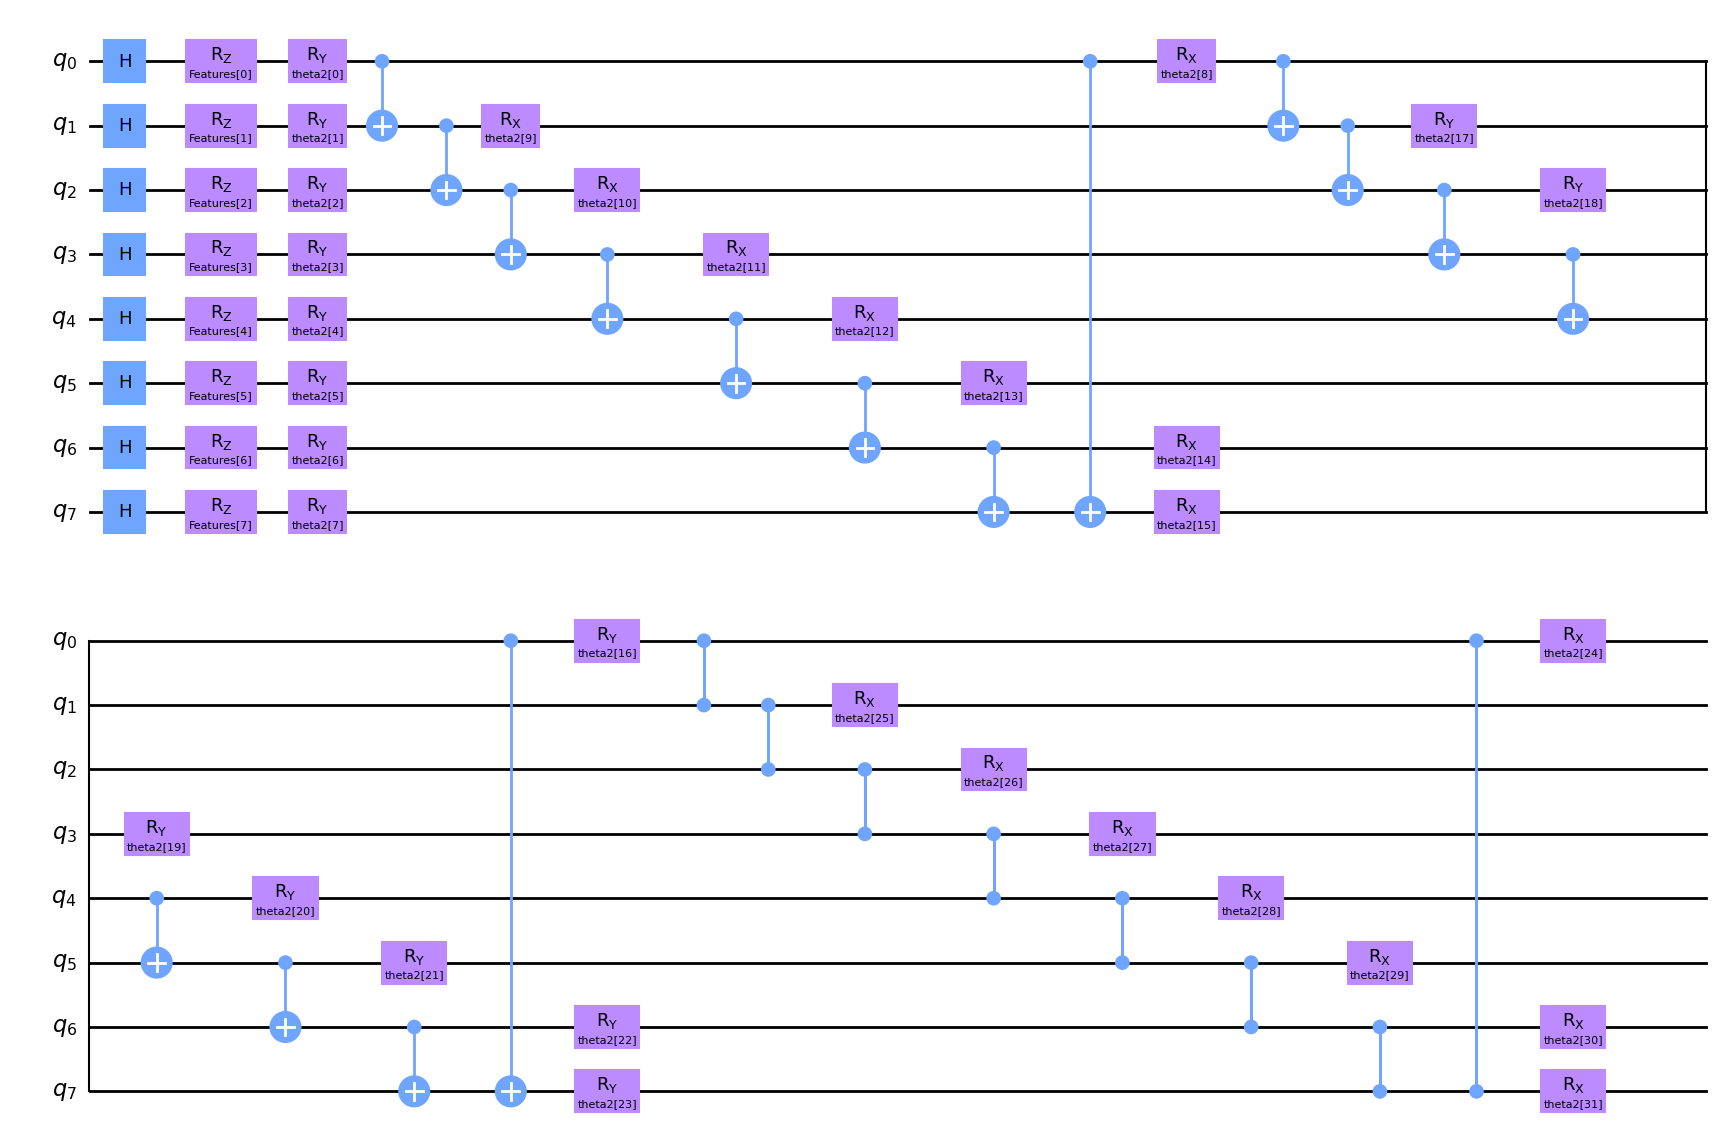

In [21]:
#New ANGLE ENCODING made to fit more qbits
encoder = QuantumCircuit(num_features)

#Input Vector for encoding the features
ip = ParameterVector('Features',num_features) 

for i in range(num_features):
    encoder.h(i)
    encoder.rz(ip[i], i)

#8 qbit ansatz
ansatz2 = QuantumCircuit(num_features)

theta2 = ParameterVector('theta2', 4 * num_features)


for i in range(num_features):
    ansatz2.ry(theta2[i], i)

for i in range(num_features - 1):
    ansatz2.cx(i, i + 1)

ansatz2.cx(0, num_features-1)

for i in range(num_features):
    ansatz2.rx(theta2[i + num_features], i)

for i in range(num_features - 1):
    ansatz2.cx(i, i + 1)

ansatz2.cx(0, num_features-1)

for i in range(num_features):
    ansatz2.ry(theta2[i + (2*num_features)], i)
    
    
for i in range(num_features - 1):
    ansatz2.cz(i, i + 1)

ansatz2.cz(0, num_features-1)

for i in range(num_features):
    ansatz2.rx(theta2[i + (3*num_features)], i)


#Combine encoder and ansatz for our seccond circuit
qc2 = QuantumCircuit(num_features)
qc2.compose(encoder, inplace=True)
qc2.compose(ansatz2, inplace=True)

qc2.draw('mpl')  # Draw the quantum circuit

In [22]:
#QNN for seccond circuit
sampler_qnn_2 = SamplerQNN(circuit=qc2, input_params=ip, weight_params=theta2, interpret=three_classes,output_shape=3)
print(f"Number of input features for SamplerQNN: {sampler_qnn_2.num_inputs}")
print(f"Number of trainable weights for SamplerQNN: {sampler_qnn_2.num_weights}")
print(f"Number of qbits for this circuit is {num_features} qbits")

Number of input features for SamplerQNN: 8
Number of trainable weights for SamplerQNN: 32
Number of qbits for this circuit is 8 qbits


Epoch 1 - Training Loss: 1.1502, Validation Loss: 1.0173
Epoch 2 - Training Loss: 1.1349, Validation Loss: 0.9930
Epoch 3 - Training Loss: 1.1221, Validation Loss: 0.9737
Epoch 4 - Training Loss: 1.1095, Validation Loss: 0.9567
Epoch 5 - Training Loss: 1.0968, Validation Loss: 0.9395
Epoch 6 - Training Loss: 1.0852, Validation Loss: 0.9211
Epoch 7 - Training Loss: 1.0742, Validation Loss: 0.9000
Epoch 8 - Training Loss: 1.0630, Validation Loss: 0.8767
Epoch 9 - Training Loss: 1.0523, Validation Loss: 0.8556
Epoch 10 - Training Loss: 1.0437, Validation Loss: 0.8402
Epoch 11 - Training Loss: 1.0369, Validation Loss: 0.8291
Epoch 12 - Training Loss: 1.0313, Validation Loss: 0.8205
Epoch 13 - Training Loss: 1.0270, Validation Loss: 0.8142
Epoch 14 - Training Loss: 1.0241, Validation Loss: 0.8101
Epoch 15 - Training Loss: 1.0222, Validation Loss: 0.8077
Epoch 16 - Training Loss: 1.0211, Validation Loss: 0.8064
Epoch 17 - Training Loss: 1.0203, Validation Loss: 0.8056
Epoch 18 - Training Los

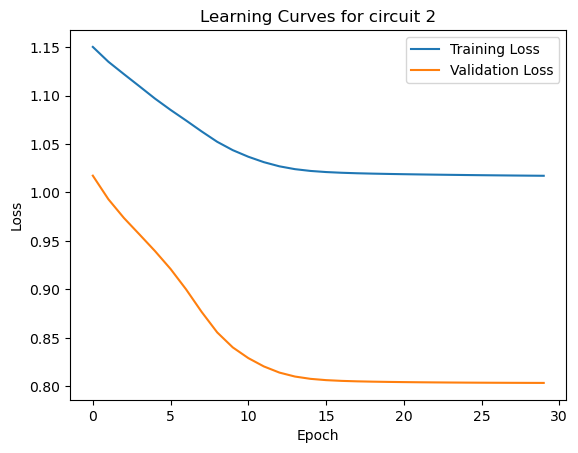

In [23]:
#Train second circuit using grad descent
start = time.time()
trained_weights_2, train_losses_2, val_losses_2 = gradient_descent_with_early_stopping(sampler_qnn_2, X_train, y_train, X_val, y_val
                                                                                ,learning_rate=0.1, epochs = 30)
elapsed = time.time() - start

# Plotting for circuit 2
plt.plot(train_losses_2, label='Training Loss')
plt.plot(val_losses_2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves for circuit 2')
plt.show()

In [24]:
print(f"Training time for circuit 2 with 8 qbits is: {round(elapsed)} seconds")
#Validation acc for circuit 2
predicted_labels_v_2 = predict(sampler_qnn_2, X_val, trained_weights_2)
val_accuracy_2 = accuracy_score(y_val, predicted_labels_v_2)
print(f"Validation Accuracy: {val_accuracy_2 * 100:.2f}% for circuit 2")

#Train acc for circuit 1
predicted_labels_t_2 = predict(sampler_qnn_2, X_train, trained_weights_2)
train_accuracy_2 = accuracy_score(y_train, predicted_labels_t_2)
print(f"Train Accuracy: {train_accuracy_2 * 100:.2f}% for circuit 2")

#Test acc for circuit 2
predicted_labels_2 = predict(sampler_qnn_2, X_test, trained_weights_2)
test_accuracy_2 = accuracy_score(y_test, predicted_labels_2)


Training time for circuit 2 with 8 qbits is: 1743 seconds
Validation Accuracy: 90.91% for circuit 2
Train Accuracy: 58.10% for circuit 2


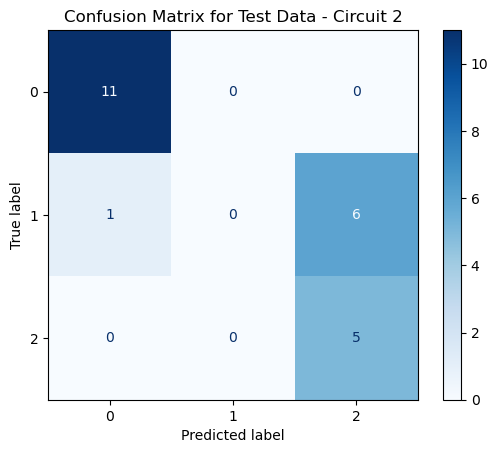

Test Accuracy: 69.57% for circuit 2


In [25]:
# Calculate confusion matrix for test data
cm_test_2 = confusion_matrix(np.argmax(y_test, axis=1), predicted_labels_2)

# Displaying the confusion matrix using Matplotlib
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test_2)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Test Data - Circuit 2")
plt.show()

print(f"Test Accuracy: {test_accuracy_2 * 100:.2f}% for circuit 2")